In [1]:
!pip install -Uq wandb
!export WANDB_API_KEY="e0aa96a51411bd4bc5a669e117bd1961648ff00e"

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: gaston-lm (carrostp3). Use `wandb login --relogin` to force relogin


True

In [1]:
# Importo las librerías necesarias.
import os
import gc
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as td
import torchaudio.transforms as tt
from torchaudio.datasets import GTZAN
import matplotlib
import matplotlib.pyplot as plt
# import itertools
from google.colab import drive

In [2]:
# Utilizo GPU de estar disponible.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Seteo una semilla para replicabilidad.
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

cuda:0


In [3]:
# Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos
drive.mount('/content/drive')
data_dir = '//content/drive/MyDrive/UTDT/TD6/genres_5sec/'
list_files = os.listdir(data_dir)

# Obtenemos las clases (géneros)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)

# Funciones auxiliares para la clase del dataset
samplerate=22050

# Para obtener generos
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

# Para definir transformación de audios (esto es data leakage hacerlo a todo? hay distintas formas: chequear clasificador.ipynb)
def transform(audio):
    return tt.Spectrogram()(audio)

# Definimos clase para obtener el dataset
class MusicDataset():
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        self.transform = tt.Spectrogram()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        fname = self.files[i]
        genre = parse_genres(fname)
        fpath = os.path.join(self.root,genre, fname)
        class_idx = self.classes.index(genre)
        audio = torchaudio.load(fpath)[0]
        spectrogram = self.transform(audio)

        return audio, spectrogram, class_idx

dataset = MusicDataset(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Hiperparámetros
batch_size = 20
learning_rate = 0.02
epochs = 40
latent_size = 55112
experiment_name = 're-run'
loss_type = "RMSE"
project_name = 'TP4'

In [5]:
ic1, ic2, ic3 = 4, 6, 8
ks1, ks2, ks3 = 10, 5, 3
s1, s2, s3 = 4, 2, 2
p1, p2, p3 = 0, 0, 0

# Definición del encoder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, ic1, kernel_size=ks1, stride=s1, padding=p1),
            nn.Tanh(),
            nn.Conv1d(ic1, ic2, kernel_size=ks2, stride=s2, padding=p2),
            nn.Tanh(),
            nn.Conv1d(ic2, ic3, kernel_size=ks3, stride=s3, padding=p3),
            nn.Tanh(),
        )
        self.latent_space = nn.Flatten()

    def forward(self, x):
        x = self.encoder(x)
        latent_rep = self.latent_space(x)
        return latent_rep

# Definición del decoder
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.unflatten = nn.Unflatten(1, (8, 6889))
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(ic3, ic2, kernel_size=ks3, stride=s3, padding=p3),
            nn.Tanh(),
            nn.ConvTranspose1d(ic2, ic1, kernel_size=ks2, stride=s2, padding=p2),
            nn.Tanh(),
            nn.ConvTranspose1d(ic1, 1, kernel_size=ks1, stride=s1, padding=p1),
        )

    def forward(self, x):
        x = self.unflatten(x)
        reconstructed_seq = self.decoder(x)
        return reconstructed_seq

# Definición del Convolutional Autoencoder (CAE)
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_rep = self.encoder(x)
        reconstructed_seq = self.decoder(latent_rep)
        return reconstructed_seq, latent_rep

In [6]:
# Definición del modelo
model = CAE()
model.to(device)
print(model)

# Configuración de wandb
wandb.init(
    project = project_name,
    name = experiment_name,
    config = {
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "latent_size": latent_size,
        "loss_type": loss_type
    }
)

CAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv1d(1, 4, kernel_size=(10,), stride=(4,))
      (1): Tanh()
      (2): Conv1d(4, 6, kernel_size=(5,), stride=(2,))
      (3): Tanh()
      (4): Conv1d(6, 8, kernel_size=(3,), stride=(2,))
      (5): Tanh()
    )
    (latent_space): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Decoder(
    (unflatten): Unflatten(dim=1, unflattened_size=(8, 6889))
    (decoder): Sequential(
      (0): ConvTranspose1d(8, 6, kernel_size=(3,), stride=(2,))
      (1): Tanh()
      (2): ConvTranspose1d(6, 4, kernel_size=(5,), stride=(2,))
      (3): Tanh()
      (4): ConvTranspose1d(4, 1, kernel_size=(10,), stride=(4,))
    )
  )
)


In [7]:
# Divido en training, validation, testing.
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

generator = torch.Generator().manual_seed(SEED)
train_ds, val_ds, test_ds = td.random_split(dataset, [train_size, val_size, test_size], generator)

train_dl = td.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = td.DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_dl = td.DataLoader(test_ds,1, num_workers=2, pin_memory=True)

In [8]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps

    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [9]:
# Definición de función de perdida
criterion = RMSELoss()
# Definición del optimizador
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Importante para ir liberando memoria ram
torch.cuda.empty_cache()
gc.collect()

lowest_loss = 1000
best_epoch = -1

for epoch in range(epochs):
    train_losses = []
    # Entrenamiento
    model.train()
    for batch in train_dl:
        optimizer.zero_grad()  # Clear gradients

        inputs, _, _ = batch
        inputs = inputs.to(device)
        # Forward pass
        outputs, _ = model(inputs)

        # Compute reconstruction loss
        loss = criterion(outputs, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Importante para ir liberando memoria ram
        del inputs
        del loss
        del outputs
        torch.cuda.empty_cache()
        gc.collect()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in valid_dl:
            inputs, _, _ = batch
            inputs = inputs.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            val_losses.append(loss.item())

    # Importante para ir liberando memoria ram
    del inputs
    del loss
    del outputs
    torch.cuda.empty_cache()
    gc.collect()

    # Para estadisticas de wandb
    if val_losses[-1] < lowest_loss:
        lowest_loss = val_losses[-1]
        best_epoch = epoch
        best_model_state_dict = model.state_dict()

    # wandb.log({"train_loss": train_losses[-1], "val_loss": val_losses[-1]})

    # Print progress
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}')

# Indico por consola cuando finalizó el entrenamiento
print(f"Entrenamiento finalizado, la loss más baja fue {str(lowest_loss)} la mejor epoch:{str(best_epoch)}")

# wandb.log({"lowest_loss": lowest_loss, "best_epoch": best_epoch})

# Guardo el modelo entrenado en disco
PATH = './cae.pth'
torch.save(best_model_state_dict, PATH)
# wandb.finish()

Epoch [1/40], Training Loss: 0.1429, Validation Loss: 0.0934
Epoch [2/40], Training Loss: 0.0921, Validation Loss: 0.0714
Epoch [3/40], Training Loss: 0.0811, Validation Loss: 0.0817
Epoch [4/40], Training Loss: 0.0756, Validation Loss: 0.0645
Epoch [5/40], Training Loss: 0.0683, Validation Loss: 0.0573
Epoch [6/40], Training Loss: 0.0646, Validation Loss: 0.0543
Epoch [7/40], Training Loss: 0.0613, Validation Loss: 0.0500
Epoch [8/40], Training Loss: 0.0576, Validation Loss: 0.0482
Epoch [9/40], Training Loss: 0.0592, Validation Loss: 0.0531
Epoch [10/40], Training Loss: 0.0566, Validation Loss: 0.0483
Epoch [11/40], Training Loss: 0.0518, Validation Loss: 0.0451
Epoch [12/40], Training Loss: 0.0499, Validation Loss: 0.0500
Epoch [13/40], Training Loss: 0.0508, Validation Loss: 0.0546
Epoch [14/40], Training Loss: 0.0528, Validation Loss: 0.0428
Epoch [15/40], Training Loss: 0.0491, Validation Loss: 0.0402
Epoch [16/40], Training Loss: 0.0475, Validation Loss: 0.0421
Epoch [17/40], Tr

In [10]:
# Load the best model
S = torch.load('cae.pth')
model.load_state_dict(S)

<All keys matched successfully>

In [11]:
model.eval()

reconstructed_audios_list = []
latent_vector_list = []
for audio, _, _ in test_dl:

    audio = audio.to(device)

    with torch.no_grad():
        # Forward pass
        reconstructed_output, latent_vec = model(audio)
        # Save the reconstructed output to the list
        reconstructed_audios_list.append(reconstructed_output.squeeze(0).cpu())
        # Save the latent vector to the list
        latent_vector_list.append(latent_vec.cpu())

In [18]:
wav, spec, label = test_dl.dataset[2]
reconstructed_audio = reconstructed_audios_list[2]

In [28]:
labels = []
for audio in test_dl:
    label = audio[2].item()
    labels.append(label)

labels

[1,
 0,
 3,
 0,
 4,
 4,
 0,
 1,
 0,
 3,
 2,
 1,
 4,
 2,
 4,
 1,
 0,
 0,
 0,
 4,
 0,
 3,
 0,
 1,
 1,
 2,
 0,
 1,
 3,
 0,
 0,
 1,
 1,
 1,
 4,
 2,
 0,
 1,
 3,
 1,
 4,
 2,
 2,
 0,
 2,
 0,
 2,
 1,
 3,
 3,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 3,
 4,
 3,
 2,
 3,
 2,
 1,
 4,
 1,
 2,
 2,
 4,
 3,
 0,
 0,
 2,
 2,
 3,
 0,
 3,
 1,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 2,
 3,
 1,
 4,
 1,
 3,
 1,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0]

In [24]:
latent_vector_list[0].size()

torch.Size([1, 55112])

In [25]:
concatenated_array = np.concatenate([tensor.numpy() for tensor in latent_vector_list], axis=0)
concatenated_array[0]
# Export the concatenated array as a NumPy file
np.save('latent_vector_55112.npy', concatenated_array)

In [20]:
import IPython
IPython.display.Audio(wav, rate=22050)

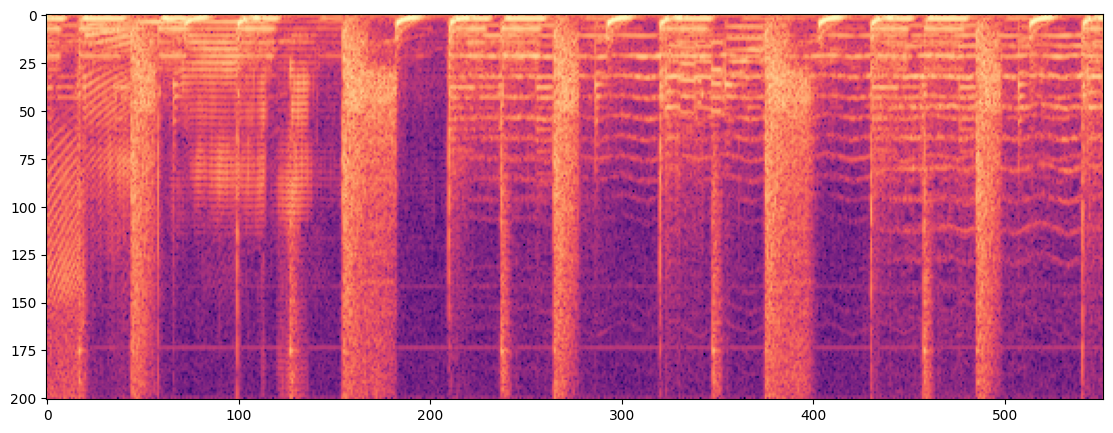

In [15]:
plt.figure(figsize=(20, 5))
plt.imshow(spec.log2()[0,:,:].numpy(),cmap='magma')

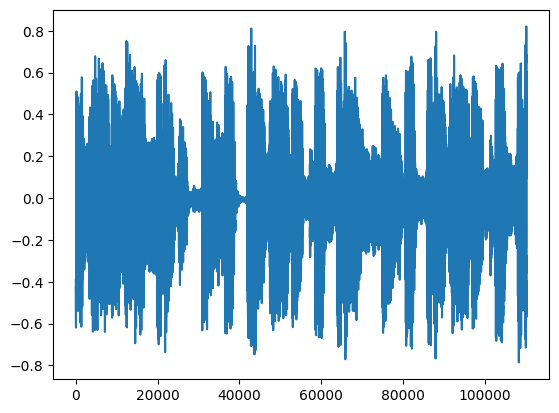

In [17]:
plt.figure()
plt.plot(wav.t().numpy())

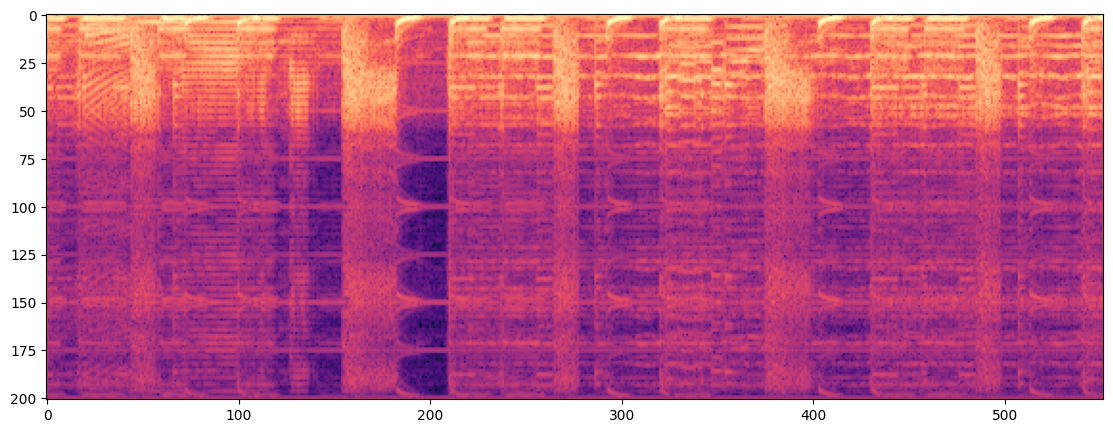

In [16]:
reconstructed_spec = transform(reconstructed_audio)

plt.figure(figsize=(20, 5))
plt.imshow(reconstructed_spec.log2()[0,:,:].numpy(),cmap='magma')

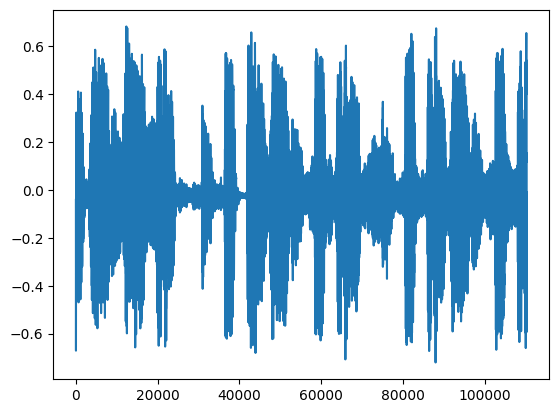

In [19]:
plt.figure()
plt.plot(reconstructed_audio.t().numpy())

In [21]:
IPython.display.Audio(reconstructed_audio, rate=22050)

In [21]:
# Create new song?
song1 = latent_vector_list[1]
song2 = latent_vector_list[2]
song3 = latent_vector_list[3]

stacked_tensors = np.stack((song1, song2, song3))

# Calculate the mean along the new axis (axis 0)
mean_tensor = np.mean(stacked_tensors, axis=0)

new_latent_vector = torch.tensor(mean_tensor)

new_latent_vector.size()

torch.Size([1, 18376])

In [22]:
# Move the model to CPU
decoder = model.decoder.cpu()
with torch.no_grad():
    new_audio = decoder(new_latent_vector).squeeze(0)

In [23]:
new_audio.size()

torch.Size([1, 110250])

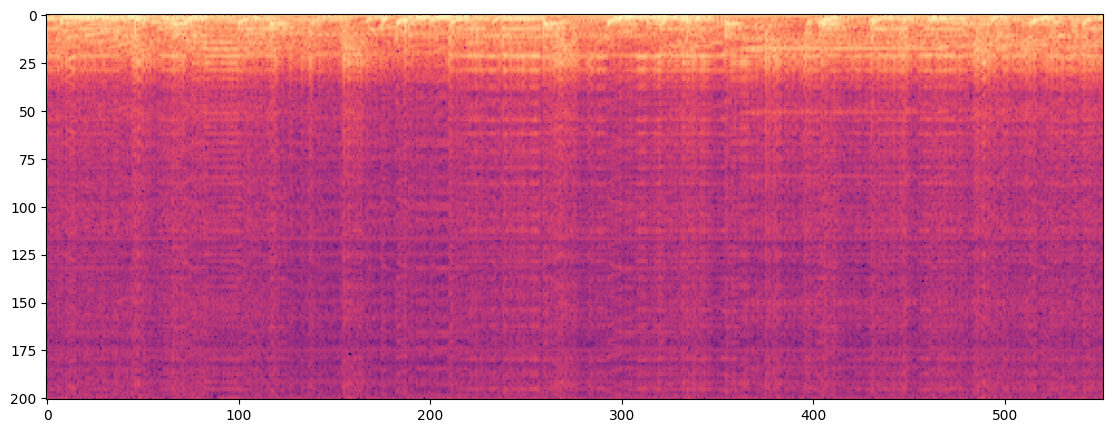

In [24]:
new_audio_spec = transform(new_audio)

plt.figure(figsize=(20, 5))
plt.imshow(new_audio_spec.log2()[0,:,:].numpy(),cmap='magma')

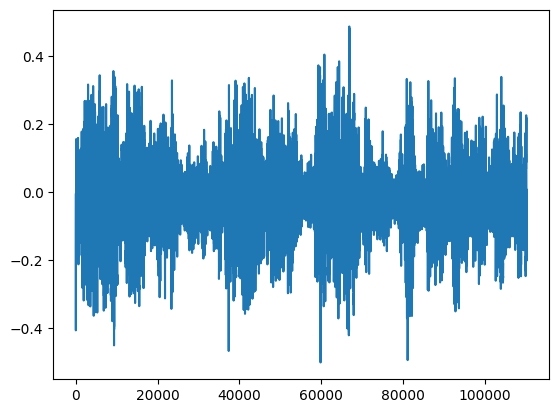

In [25]:
plt.figure()
plt.plot(new_audio.t().numpy())

In [26]:
IPython.display.Audio(new_audio, rate=22050)

In [19]:
# Ejemplo dimensiones
original = torch.rand(20, 1, 110250)
print(original.size())

def convoluciones(original):
    vr = nn.Sequential(
                nn.Conv1d(1, ic1, kernel_size=ks1, stride=s1, padding=p1),
                nn.ReLU(),
                nn.Conv1d(ic1, ic2, kernel_size=ks2, stride=s2, padding=p2),
                nn.ReLU(),
                nn.Conv1d(ic2, ic3, kernel_size=ks3, stride=s3, padding=p3),
                nn.ReLU(),
              )

    return vr(original)

def tranpuesta(latent):
    vr = nn.Sequential(
                nn.ConvTranspose1d(ic3, ic2, kernel_size=ks3, stride=s3, padding=p3),
                nn.ReLU(),
                nn.ConvTranspose1d(ic2, ic1, kernel_size=ks2, stride=s2, padding=p2),
                nn.ReLU(),
                nn.ConvTranspose1d(ic1, 1, kernel_size=ks1, stride=s1, padding=p1),
            )
    return vr(latent)

ic1, ic2, ic3 = 4, 6, 8
ks1, ks2, ks3 = 10, 5, 3
s1, s2, s3 = 4, 2, 2
p1, p2, p3 = 0, 0, 0

new_tensor = convoluciones(original)
print(new_tensor.size())
func = nn.Flatten()
flateneado = func(new_tensor)
print(flateneado.size())

reverse = nn.Unflatten(1, (new_tensor.size()[1], new_tensor.size()[2]))
unflat = reverse(flateneado)
print(unflat.size())

decodeade = tranpuesta(unflat)
print(decodeade.size())

torch.Size([20, 1, 110250])
torch.Size([20, 8, 6889])
torch.Size([20, 55112])
torch.Size([20, 8, 6889])
torch.Size([20, 1, 110250])


In [28]:
def chequear_division_entera(ic1, ic2, ic3, ks1, ks2, ks3, s1, s2, s3, p1, p2, p3):
    d1 = (110250 + 2 * p1 - (ks1-1) - 1)

    if d1 % s1 != 0:
        print("d1= " + str(d1))
        return 0

    l_out1 = d1/s1 + 1

    print(f"primera capa= {l_out1*ic1}")

    d2 = (l_out1 + 2 * p2 - (ks2-1) - 1)

    if d2 % s2 != 0:
        print("d2= " + str(d2))
        return 0

    l_out2 = d2/s2 + 1

    print(f"segunda capa= {l_out2*ic2}")

    d3 = (l_out2 + 2 * p3 - (ks3-1) - 1)

    if d3 % s3 != 0:
        print("d3= " + str(d3))
        return 0

    l_out3 = d3/s3 + 1

    print(f"tercer capa= {l_out3*ic3}")

    return "debería funcar"

chequear_division_entera(ic1, ic2, ic3, ks1, ks2, ks3, s1, s2, s3, p1, p2, p3)

# # Define the possible values for each parameter
# ic1_values = [1]
# ic2_values = [8,16,32,64]
# ic3_values = [8,16,32,64]

# ks1_values = [3, 4, 5]
# ks2_values = [2, 3, 4]
# ks3_values = [1, 2, 3]

# s1_values = [1, 2, 3]
# s2_values = [2, 3, 4]
# s3_values = [1, 2, 3]

# p1_values = [0, 1, 2]
# p2_values = [1, 2, 3]
# p3_values = [2, 3, 4]

# # Create all possible combinations of parameter values
# combinations = itertools.product(
#     ic1_values, ic2_values, ic3_values,
#     ks1_values, ks2_values, ks3_values,
#     s1_values, s2_values, s3_values,
#     p1_values, p2_values, p3_values
# )

# # Iterate over combinations
# with open('output.txt', 'w') as file:
#   for combination in combinations:
#       result = chequear_division_entera(*combination)
#       if result == "debería funcar":
#           file.write(f"Combination found: {combination} \n")

primera capa= 91870.0
segunda capa= 27558.0
tercer capa= 18376.0


'debería funcar'